References

- https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
- https://realpython.com/python-opencv-color-spaces/

HSV stands for **Hue, Saturation, and Value (or brightness)**, and is a cylindrical color space. The colors, or hues, are modeled as an angular dimension rotating around a central, vertical axis, which represents the value channel. Values go from dark (0 at the bottom) to light at the top. The third axis, saturation, defines the shades of hue from least saturated, at the vertical axis, to most saturated furthest away from the center.


In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Resize images to at most 64 rows and columns
N_resize = 256
N_border_x = 500
N_border_y = 300

In [3]:
def extract_color_features(img, i, N_border_x=None, N_border_y=None, N_resize=None):
    
    # Remove border pixels
    if N_border_x and N_border_y:
        img = img[N_border_y:-N_border_y,N_border_x:-N_border_x,:]
        print(img.shape)

    # Select a small fraction of pixels to plot by subsampling it
    if N_resize:
        scale = max(img.shape[0], img.shape[1], N_resize) / N_resize
        img = cv2.resize(img, 
                         ( int(img.shape[1]/scale), int(img.shape[0]/scale) ), 
                         interpolation=cv2.INTER_NEAREST)
        print(img.shape)

    # Convert subsampled image to desired color space(s)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).reshape((-1,1,3)).reshape(-1,3)  # OpenCV uses BGR, matplotlib likes RGB
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).reshape((-1,1,3)).reshape(-1,3)
    img_YIQ = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb).reshape((-1,1,3)).reshape(-1,3)
    img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).reshape((-1,1,3)).reshape(-1,3)
    img_labels = (i+1)*np.ones(img_RGB[:,0].shape, dtype=int).reshape((-1,1))

    return img_RGB, img_HSV, img_YIQ, img_LAB, img_labels, img.shape

In [4]:
# Read training color images

file_location = './sample_data/train' # path of directory
files = [file for file in os.listdir(file_location) if file.endswith(".jpg")]
print(f"{len(files)} training images.\n")

for i, curr_file in enumerate(files):
    filepath = f'{file_location}\\{curr_file}'
    img = cv2.imread(filepath)
    print(curr_file)
    print(img.shape)

    img_RGB, img_HSV, img_YIQ, img_LAB, img_labels, _ = extract_color_features(img, i, N_border_x, N_border_y, N_resize)
    
    if i==0:
        master_img_RGB = img_RGB
        master_img_HSV = img_HSV
        master_img_YIQ = img_YIQ
        master_img_LAB = img_LAB
        master_img_labels = img_labels
    else:
        master_img_RGB = np.vstack((master_img_RGB, img_RGB))
        master_img_HSV = np.vstack((master_img_HSV, img_HSV))
        master_img_YIQ = np.vstack((master_img_YIQ, img_YIQ))
        master_img_LAB = np.vstack((master_img_LAB, img_LAB))
        master_img_labels = np.vstack((master_img_labels, img_labels))

3 training images.

201106 edn wetmill kebado batch 1 green 3pm angle sun tecno.jpg
(1415, 2280, 3)
(815, 1280, 3)
(163, 256, 3)
201106 edn wetmill kebado batch 1 high ripe 3pm angle shade blackiew.jpg
(2448, 3264, 3)
(1848, 2264, 3)
(208, 256, 3)
201110 dobe wetmill aleta wondo batch 1 over ripe 4 00 pm sun.jpg
(1920, 2560, 3)
(1320, 1560, 3)
(216, 256, 3)


In [5]:
master_img_RGB.shape, master_img_HSV.shape, master_img_YIQ.shape, master_img_LAB.shape

((150272, 3), (150272, 3), (150272, 3), (150272, 3))

***

## Prepare Data for Machine Learning

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Concatenate all color features into one matrix

X = np.hstack((master_img_RGB, master_img_HSV, master_img_YIQ, master_img_LAB))
y = master_img_labels.ravel()

X.shape, y.shape

((150272, 12), (150272,))

In [10]:
# Split dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=402)
X_train.shape, X_test.shape

((112704, 12), (37568, 12))

In [11]:
pd.concat([pd.Series(y_train).value_counts(normalize=True), pd.Series(y_test).value_counts(normalize=True)], axis=1)

0         1
3  0.367715  0.368745
2  0.354202  0.354770
1  0.278082  0.276485

****

## Supervised Learning Techniques for Building Pixel Classifer

- kNearest Neighbor
- Logistic regressiong
- Naive Bayes
- Decision tree
- Random forest
- SVM (had to remove it because took too long to train)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.metrics import classification_report

In [15]:
classifiers = [
    KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='minkowski', p=2, weights='uniform'),
    LogisticRegression(solver='liblinear', penalty='l2'),
    #SVC(kernel='linear', probability=True),
    #SVC(kernel='poly', degree=2, coef0=0.0, gamma='scale', shrinking=True, probability=True, tol=0.001),
    #SVC(kernel='rbf', C=1.0, gamma='scale', shrinking=True, probability=True, tol=0.001),
    GaussianNB(priors=None, var_smoothing=1e-09),
    DecisionTreeClassifier(criterion='gini',max_depth=3,min_samples_split=2,min_samples_leaf=1,min_weight_fraction_leaf=0.0,max_features=None,random_state=None),
    RandomForestClassifier(n_estimators=10,criterion='gini',max_depth=3,min_samples_split=2,min_samples_leaf=1,min_weight_fraction_leaf=0.0,max_features='auto')]

In [16]:
import time

results_list = []

start = time.time()

for clf in classifiers:
    clf_name = clf.__class__.__name__
    print("="*30)
    print(clf_name)

    start1 = time.time()
    clf.fit(X_train, y_train)
    end1 = time.time()
        
    start2 = time.time()
    test_predictions = clf.predict(X_test)
    end2 = time.time()

    acc = accuracy_score(y_test, test_predictions)
    test_pred_prob = clf.predict_proba(X_test)
    ll = log_loss(y_test, test_pred_prob)
    #rc = roc_auc_score(y_test, test_pred_prob)

    results_list.append((clf_name, acc*100, ll, end1-start1, end2-start2))  #, rc

end = time.time()
print("total running time: %.2f seconds." %(end - start))

results_df = pd.DataFrame(results_list,columns=["Classifier", "Accuracy", "Log Loss", 'Fit_time', 'Pred_time'])  #, "ROC_AUC"
results_df.set_index('Classifier',inplace=True)

KNeighborsClassifier
LogisticRegression
GaussianNB
DecisionTreeClassifier
RandomForestClassifier
total running time: 15.43 seconds.


In [17]:
results_df

Accuracy  Log Loss  Fit_time  Pred_time
Classifier                                                      
KNeighborsClassifier    95.464225  0.788136  1.263137   4.221244
LogisticRegression      95.131495  0.171741  5.748149   0.064135
GaussianNB              90.151193  0.424170  0.077819   0.034426
DecisionTreeClassifier  91.053556  0.226848  0.792681   0.058906
RandomForestClassifier  91.109455  0.266293  1.310042   0.055232

### Tune Parameters of KNN Model

In [20]:
res_ = []

for K in np.arange(1,20,2):
    print(K)
    model = KNeighborsClassifier(n_neighbors=K, algorithm='auto', metric='minkowski', p=2, weights='uniform')
    
    # k-Fold Cross-Validation
    u = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    
    # out-of-sample performance
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    #acc = accuracy_score(y_test, model.predict(X_test))   SAME THING!!
    res_.append((K, u.mean(), u.std(), acc))

df_ = pd.DataFrame(res_, columns=['K', 'mean CV acc', 'std CV acc', 'test acc'])
df_ = df_.set_index(['K'])
df_.head()

1
3
5
7
9
11
13
15
17
19


mean CV acc  std CV acc  test acc
K                                   
1     0.944084    0.002344  0.941573
3     0.955024    0.002280  0.954642
5     0.958466    0.002014  0.957144
7     0.959611    0.001785  0.958608
9     0.959966    0.001855  0.959327

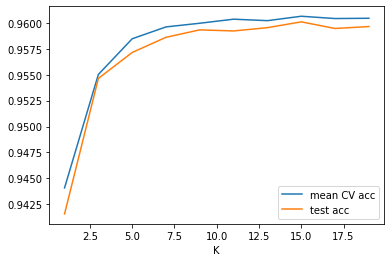

In [21]:
df_[['mean CV acc', 'test acc']].plot()
plt.show()

### Build KNN Model with Best Hyper-Parameter Values

In [52]:
def apply_final_model(model, X, minConfidence=0.9):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)

    y_pred_prob_df = pd.DataFrame(y_pred_prob)
    y_pred_prob_df.columns = ['category1_prob (underripe)', 'category2_prob (ripe)', 'category3_prob (overripe)']
    
    # predicted category based on max probability
    u1 = y_pred_prob_df.apply(lambda row: row.argmax(), axis=1)
    
    # prediction confidence
    u2 = y_pred_prob_df.max(axis=1)
    
    #assert (y_pred == (u1+1)).all()
    if (y_pred != (u1+1)).any():
        print('Warning: predict_proba and predict are inconsistent on the following number and fraction of test samples:')
        print((y_pred != (u1+1)).sum(), (y_pred != (u1+1)).mean())
    
    #print('Number of test samples with low prediction confidence:')
    #print((u2<0.9).sum(), (u2<0.7).sum(), (u2<0.6).sum())
    #print('Fraction of test samples with low prediction confidence:')
    #print((u2<0.9).mean(), (u2<0.7).mean(), (u2<0.6).mean())

    y_pred_prob_df['predicted_category'] = y_pred
    y_pred_prob_df['prediction_confidence'] = u2
    temp_df = y_pred_prob_df.apply(lambda x: x.predicted_category if x.prediction_confidence>=minConfidence else 4, axis=1)
    y_pred_ext = temp_df.values
    
    print('Distribution of pixels by predicted category:')
    print(temp_df.value_counts().sort_index())

    print('For debugging -- number of pixels classified as OTHER:', (y_pred_ext!=y_pred).sum())
    print()
    

    return y_pred_ext

In [43]:
def test_final_model(model, minConfidence=0.9):
    print("Building model on training set ...")
    model.fit(X_train, y_train)
    print(f"Model accuracy on test set: {model.score(X_test, y_test)}")
    
    y_pred = model.predict(X_test)
    
    # Confusion matrix
    print('Confusion matrix:')
    print(pd.crosstab(y_test, y_pred))

    print('Classification report:')
    print(classification_report(y_test, y_pred, model.classes_, digits=3, output_dict=False))
    #pd.DataFrame(classification_report(y_test, y_pred, model.classes_, digits=3, output_dict=True))
    
    y_pred_prob = model.predict_proba(X_test)
    y_pred_df = pd.DataFrame(y_pred_prob)
    y_pred_df.columns = ['category1_prob (underripe)', 'category2_prob (ripe)', 'category3_prob (overripe)']

    u1 = y_pred_df.apply(lambda row: row.argmax(), axis=1)
    u2 = y_pred_df.max(axis=1)
    
    #assert (y_pred == (u1+1)).all()
    if not (y_pred == (u1+1)).all():
        print('Warning: predict_proba and predict are inconsistent on the following number and fraction of test samples:')
        print((y_pred != (u1+1)).sum(), (y_pred != (u1+1)).mean())
    
    #print('Number of test samples with low prediction confidence:')
    #print((u2<0.9).sum(), (u2<0.7).sum(), (u2<0.6).sum())
    #print('Fraction of test samples with low prediction confidence:')
    #print((u2<0.9).mean(), (u2<0.7).mean(), (u2<0.6).mean())

    y_pred_df['predicted_category'] = y_pred
    y_pred_df['true_category'] = y_test
    y_pred_df['prediction_confidence'] = u2
    y_pred_df['predicted_category_ext'] = y_pred_df.apply(lambda x: x.predicted_category if x.prediction_confidence>=minConfidence else 4, axis=1)
    y_pred_ext = y_pred_df.predicted_category_ext.values
    
    #print('For debugging: ', type(y_pred_ext), y_pred_ext.shape)
    #print('For debugging: ', (y_pred_ext==y_pred).sum())
    #print()

    # Confusion matrix
    print('Extended Confusion Matrix:')
    print(pd.crosstab(y_test, y_pred_ext))

    print('Extended Classification Report:')
    print(classification_report(y_test, y_pred_ext, model.classes_, digits=3, output_dict=False))
    
    plt.subplot(1,2,1)
    y_pred_df.prediction_confidence.plot.hist()
    plt.subplot(1,2,2)
    y_pred_df.prediction_confidence.plot.box()
    plt.show()
       
    sns.boxplot(x='true_category', y='prediction_confidence', data=y_pred_df)
    plt.title('Distribution of prediction confidence by category')
    plt.show()
    
    return y_pred_df

Building model on training set ...
Model accuracy on test set: 0.958927810902896
Confusion matrix:
col_0      1      2      3
row_0                     
1      10337      0     50
2          5  12579    744
3         43    701  13109
Classification report:
              precision    recall  f1-score   support

           1      0.995     0.995     0.995     10387
           2      0.947     0.944     0.946     13328
           3      0.943     0.946     0.945     13853

    accuracy                          0.959     37568
   macro avg      0.962     0.962     0.962     37568
weighted avg      0.959     0.959     0.959     37568



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Number of test samples with low prediction confidence:
3507 1077 335
Fraction of test samples with low prediction confidence:
0.09335072402044294 0.028668015332197615 0.008917163543441227
<class 'numpy.ndarray'> (37568,)
For debugging:  34061

Extended Confusion Matrix:
col_0    1.0    2.0    3.0   4.0
row_0                           
1      10280      0     18    89
2          2  11468    343  1515
3         10    224  11716  1903
Extended Classification Report:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

           1      0.999     0.990     0.994     10387
           2      0.981     0.860     0.917     13328
           3      0.970     0.846     0.904     13853

   micro avg      0.982     0.891     0.934     37568
   macro avg      0.983     0.899     0.938     37568
weighted avg      0.982     0.891     0.933     37568



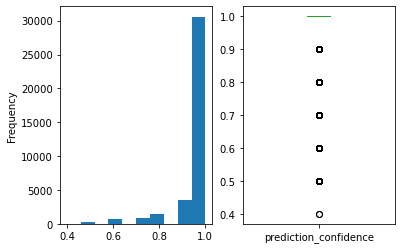

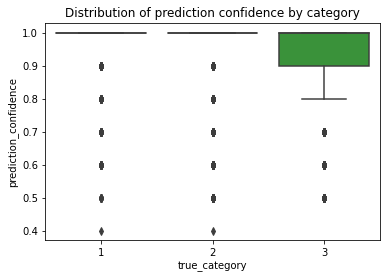

In [44]:
knn_model = KNeighborsClassifier(n_neighbors=10, algorithm='auto', metric='minkowski', p=2, weights='uniform')

knn_y_pred_df = test_final_model(knn_model)

In [94]:
## Logistic regression model
# logreg_model = LogisticRegression()
# logreg_y_pred_df = test_final_model(logreg_model)

## Display pixel classification results on training images

In [92]:
# unripe --> green, ripe --> yellow, overripe --> red, Other --> black
category_color_labels = [(0,255,0),(255,165,0),(255,0,0),(0,0,0)]

(815, 1280, 3)
(163, 256, 3)
Number of test samples with low prediction confidence:
354 148 46
Fraction of test samples with low prediction confidence:
0.00848351226993865 0.0035467791411042944 0.0011023773006134969
Distribution of pixels by predicted category:
1.0    41450
2.0        2
3.0      128
4.0      148
dtype: int64
For debugging -- number of pixels classified as OTHER: 148



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


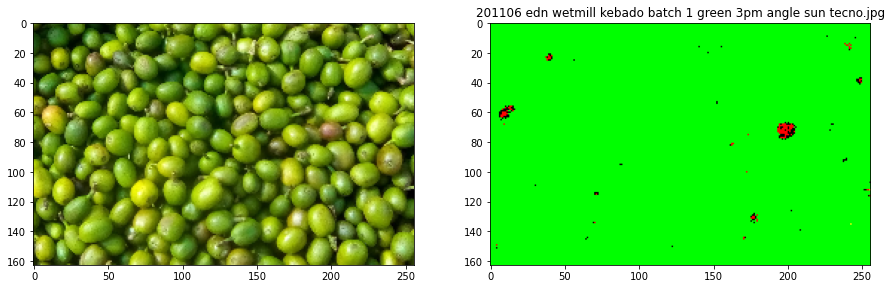

(1848, 2264, 3)
(208, 256, 3)
Number of test samples with low prediction confidence:
6151 1962 632
Fraction of test samples with low prediction confidence:
0.11551607572115384 0.03684645432692308 0.011868990384615384
Distribution of pixels by predicted category:
1.0       10
2.0    49233
3.0     2043
4.0     1962
dtype: int64
For debugging -- number of pixels classified as OTHER: 1962



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


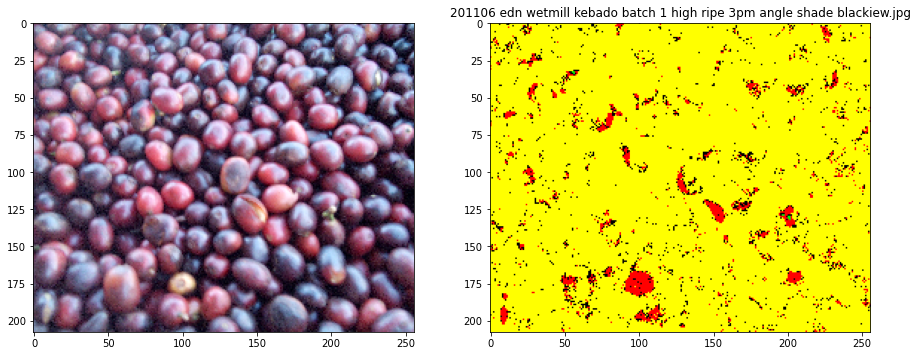

(1320, 1560, 3)
(216, 256, 3)
Number of test samples with low prediction confidence:
7382 2056 645
Fraction of test samples with low prediction confidence:
0.13349971064814814 0.037181712962962965 0.011664496527777778
Distribution of pixels by predicted category:
1.0       55
2.0     1527
3.0    51658
4.0     2056
dtype: int64
For debugging -- number of pixels classified as OTHER: 2056



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


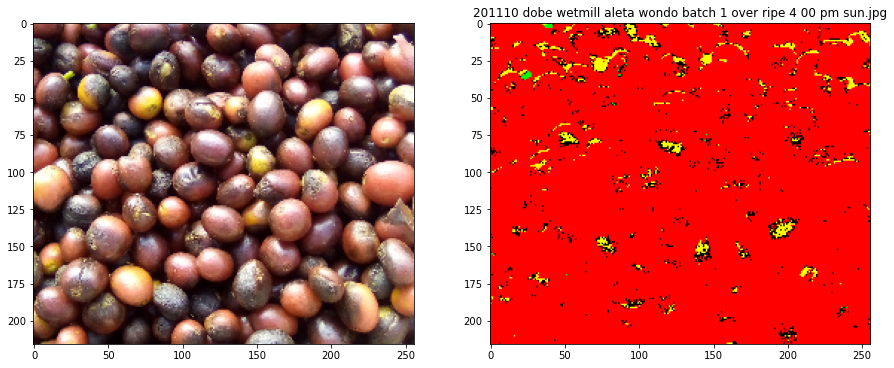

In [93]:
# Read images

file_location = './sample_data/train'
files = [file for file in os.listdir(file_location) if file.endswith(".jpg")]

for i, curr_file in enumerate(files):
    filepath = f'{file_location}\\{curr_file}'
    img = cv2.imread(filepath)
    #print(curr_file)
    #print(img.shape)

    img_RGB_, img_HSV_, img_YIQ_, img_LAB_, img_labels_, new_img_shape = extract_color_features(img, i, N_border_x, N_border_y, N_resize)

    # Concatenate all color features into one matrix
    X_ = np.hstack((img_RGB_, img_HSV_, img_YIQ_, img_LAB_))
    
    # Classify pixels
    y_pred = apply_final_model(knn_model, X_, minConfidence=0.7)
    assert len(np.unique(y_pred)) <= 4

    y_pred_img = y_pred.reshape(new_img_shape[:2])
    y_pred_img_rgb = np.empty(new_img_shape)

    y_pred_img = y_pred.reshape(new_img_shape[:2])
    y_pred_img_rgb = np.empty(new_img_shape)
    for r in range(y_pred_img.shape[0]):
        for c in range(y_pred_img.shape[1]):
            y_pred_img_rgb[r,c,:] = category_color_labels[int(y_pred_img[r,c])-1]

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(img_RGB_.reshape(new_img_shape))
    plt.subplot(1, 2, 2)
    plt.imshow(y_pred_img_rgb)  #, cmap='gray'
    plt.title(curr_file)
    plt.savefig(f"./output/{curr_file[:-4]}_out.png")
    plt.show()
    
    #break

## Display pixel classification results on test images

2010285pm dale woreda Coop 19etb Bag 1.jpg
(809, 1080, 3)
(383, 512, 3)
Number of test samples with low prediction confidence:
67475 25174 12307
Fraction of test samples with low prediction confidence:
0.344091669386423 0.12837589751958225 0.06276007669712794
Distribution of pixels by predicted category:
1.0      4737
2.0     15888
3.0    150297
4.0     25174
dtype: int64
For debugging -- number of pixels classified as OTHER: 25174



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


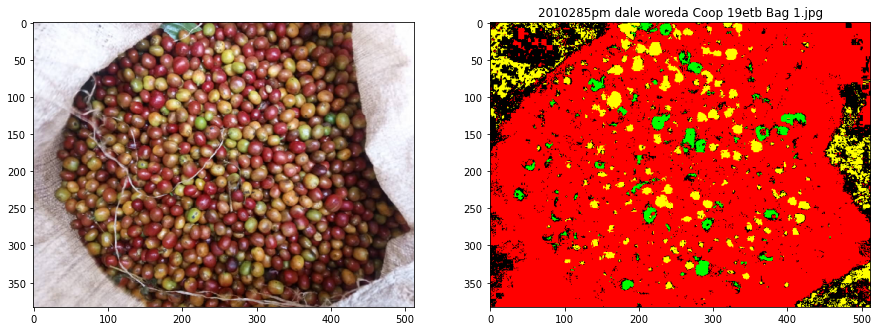

2010285pm dale woreda Coop 19etb Bag 2.jpg
(1080, 809, 3)
(512, 383, 3)
Number of test samples with low prediction confidence:
78944 29158 13963
Fraction of test samples with low prediction confidence:
0.40257832898172324 0.148692477154047 0.0712049200391645
Distribution of pixels by predicted category:
1.0    10920
2.0    98018
3.0    58000
4.0    29158
dtype: int64
For debugging -- number of pixels classified as OTHER: 29158



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


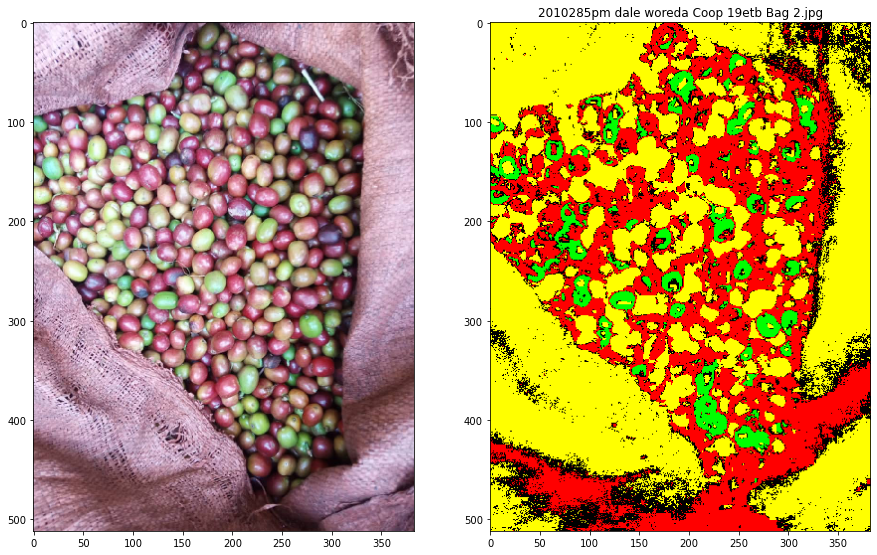

2010285pm dale woreda Coop 19etb Bag 3.jpg
(1080, 809, 3)
(512, 383, 3)
Number of test samples with low prediction confidence:
89974 37707 18506
Fraction of test samples with low prediction confidence:
0.45882628916449086 0.1922884709530026 0.09437214425587467
Distribution of pixels by predicted category:
1.0    12286
2.0    70567
3.0    75536
4.0    37707
dtype: int64
For debugging -- number of pixels classified as OTHER: 37707



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


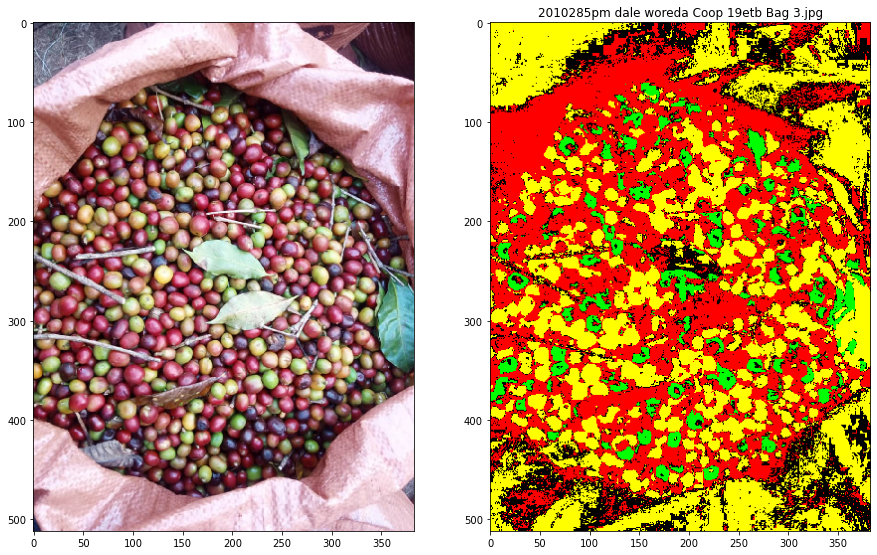

2010285pm Dale woreda Private 21etb Bag 1.jpg
(1080, 809, 3)
(512, 383, 3)
Number of test samples with low prediction confidence:
85846 29879 13892
Fraction of test samples with low prediction confidence:
0.43777537532637073 0.1523692477154047 0.07084285248041776
Distribution of pixels by predicted category:
1.0     3887
2.0    63069
3.0    99261
4.0    29879
dtype: int64
For debugging -- number of pixels classified as OTHER: 29879



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


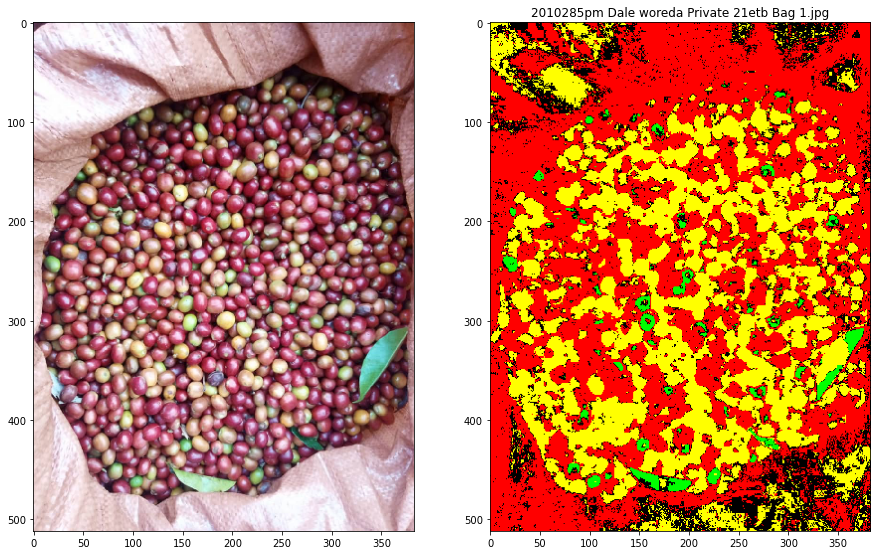

In [89]:
# Read images

file_location = './sample_data/test'
files = [file for file in os.listdir(file_location) if file.endswith(".jpg")]

for i, curr_file in enumerate(files):
    filepath = f'{file_location}\\{curr_file}'
    img = cv2.imread(filepath)
    print(curr_file)
    print(img.shape)

    img_RGB_, img_HSV_, img_YIQ_, img_LAB_, img_labels_, new_img_shape = extract_color_features(img, i, 
                                                                                 N_border_x=None, N_border_y=None, 
                                                                                 N_resize=512)

    # Concatenate all color features into one matrix
    X_ = np.hstack((img_RGB_, img_HSV_, img_YIQ_, img_LAB_))
    
    # Classify pixels
    y_pred = apply_final_model(knn_model, X_, minConfidence=0.7)
    assert len(np.unique(y_pred)) <= 4

    y_pred_img = y_pred.reshape(new_img_shape[:2])
    y_pred_img_rgb = np.empty(new_img_shape)

    y_pred_img = y_pred.reshape(new_img_shape[:2])
    y_pred_img_rgb = np.empty(new_img_shape)
    for r in range(y_pred_img.shape[0]):
        for c in range(y_pred_img.shape[1]):
            y_pred_img_rgb[r,c,:] = category_color_labels[int(y_pred_img[r,c])-1]

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(img_RGB_.reshape(new_img_shape))
    plt.subplot(1, 2, 2)
    plt.imshow(y_pred_img_rgb)  #, cmap='gray'
    plt.title(curr_file)
    plt.savefig(f"./output/{curr_file[:-4]}_out.png")
    plt.show()

*****

## Bonus: Visualize color features in 2D and 3D

In [100]:
def plot3d(pixels, color_labels, axis_labels, axis_limits=[(0, 255), (0, 255), (0, 255)], N=10000):
    idx = random.sample(range(0,pixels.shape[0]), N)
    xdata = pixels[idx, 0, 0].ravel()
    ydata = pixels[idx, 0, 1].ravel()
    zdata = pixels[idx, 0, 2].ravel()
    cdata = color_labels[idx,0]
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    ax.scatter3D(xdata, ydata, zdata, c=cdata, cmap='viridis')
    plt.show()

In [111]:
def plot2d(pixels, color_labels, axis_labels, axis_limits=[(0, 255), (0, 255), (0, 255)], N=10000):
    idx = random.sample(range(0,pixels.shape[0]), N)
    xdata = pixels[idx, 0, 0].ravel()
    ydata = pixels[idx, 0, 1].ravel()
    zdata = pixels[idx, 0, 2].ravel()
    cdata = color_labels[idx,0]

    plt.subplot(1, 3, 1)
    plt.scatter(x=xdata, y=ydata, c=cdata)
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    plt.subplot(1, 3, 2)
    plt.scatter(x=xdata, y=zdata, c=cdata)
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[2])
    plt.subplot(1, 3, 3)
    plt.scatter(x=ydata, y=zdata, c=cdata)
    plt.xlabel(axis_labels[1])
    plt.ylabel(axis_labels[2])
    plt.show()

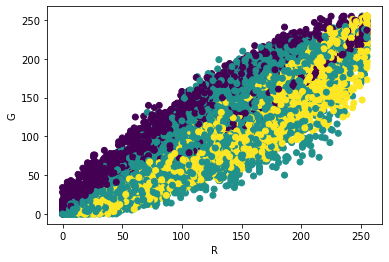

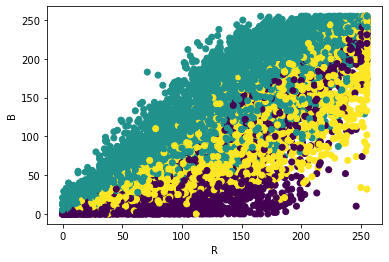

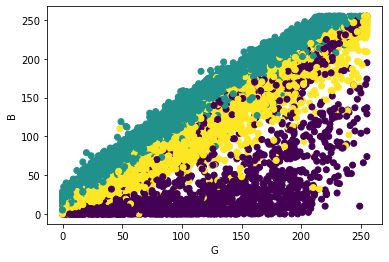

In [112]:
plot2d(pixels=master_img_RGB, color_labels=master_img_labels, axis_labels=list("RGB"))

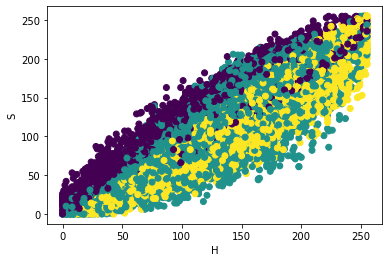

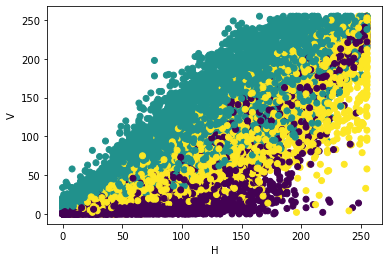

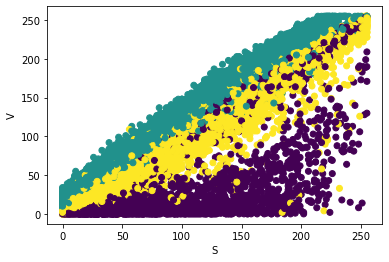

In [113]:
plot2d(pixels=master_img_RGB, color_labels=master_img_labels, axis_labels=list("HSV"))

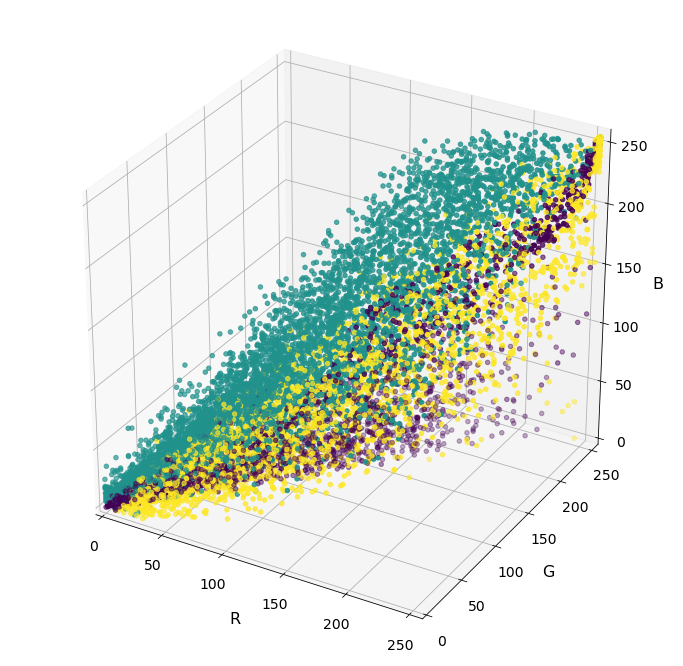

In [101]:
plot3d(pixels=master_img_RGB, color_labels=master_img_labels, axis_labels=list("RGB"))

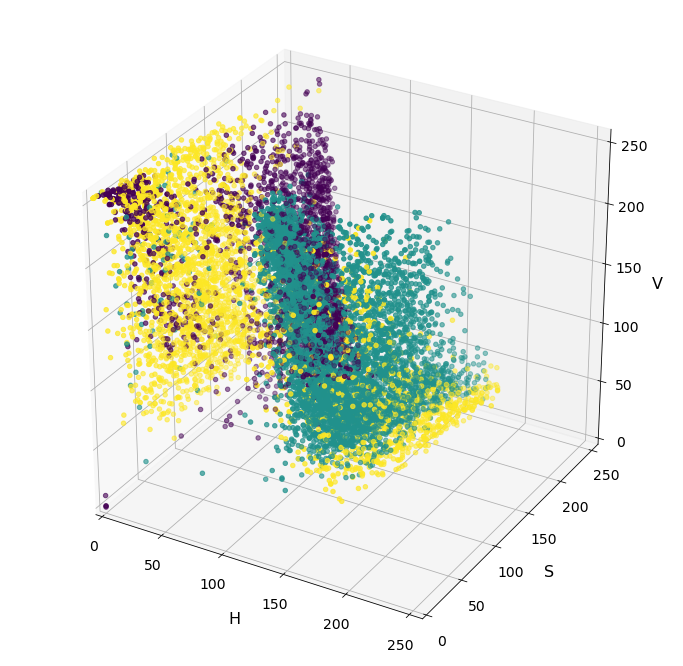

In [102]:
plot3d_mine(pixels=master_img_HSV, color_labels=master_img_labels, axis_labels=list("HSV"))